In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.layers import (BatchNormalization,Flatten,Convolution1D,Activation,Input,Dense,LSTM)
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
from keras import losses, models, optimizers
from tensorflow.keras import losses, models, optimizers
import tensorflow as tf
import random as rn
import warnings
import os

import tensorflow.python.keras.backend as K

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
%matplotlib inline

In [2]:
path=os.getcwd()+'\\'
print("path: ",path)

path:  c:\Users\Laura\Desktop\Laura\Istruzione\Data Science\Sismologia\Paper\codes\final_codes\prediction\


Exp: p 4581 , steps= 70


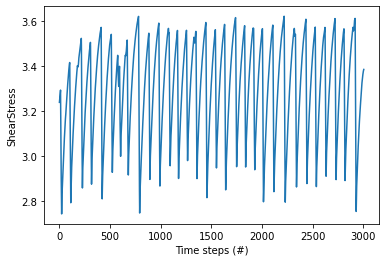

,Var_Ch1,Var_Ch2,ShearStress
0,3047.234359,3917.021969,3.239017
1,2925.553020,4311.661464,3.244192
2,2985.326386,4690.250858,3.249339
3,3079.196531,5332.662902,3.255036
4,3590.012400,5121.988307,3.260362
...,...,...,...
3000,5466.478929,3840.490299,3.378032
3001,5692.082728,4431.488788,3.380162
3002,5466.444974,4777.970790,3.382122
3003,5590.492045,4779.981216,3.383743


In [3]:
target=["ShearStress"]#["ShearStress"] or ["TimeToStartFailure"] or ["TimeToEndFailure"], or a combination of 2 
exp=4581 #4679 or 5198 or 4581

ntarget=len(target)
if exp==4581:
  steps=70
  newDF = pd.read_csv(path+'newDF_TimeToFailure_from_3800_to_4100_WITHOUT_subwindows.csv')
elif exp==5198:
  steps=70
  newDF = pd.read_csv(path+'newDF_TimeToFailure_from_6600_to_6900_WITHOUT_subwindows.csv')
elif exp==4679:
  newDF = pd.read_csv(path+'newDF_TimeToFailure_from_4340_to_4540_WITHOUT_subwindows_len003_shifth003.csv')
  if ntarget==1:
    if "TimeToStartFailure" in target or "TimeToEndFailure" in target:
      steps=1100 # best value=1100 for target=ttf
    elif "ShearStress" in target:
      steps=2000 # best value=2000 for target=shstress
    else:
      steps=1717 # other cases set=length of 1 seismic cycle
  else:
    steps=1717 # other cases set=length of 1 seismic cycle
else:
  print("Experiment not valid. Chose 4581 or 5198 or 4679.")
print("Exp: p",exp,", steps=",steps)
newDF=newDF.drop(columns="Unnamed: 0")
column=["Var_Ch1","Var_Ch2"]
for i in target:
  column.append(i)
newDF=newDF[column]#"Time"
for i in target:
  plt.plot(newDF[i])
  plt.xlabel('Time steps (#)')
  plt.ylabel(i)
  plt.show()
newDF

In [4]:
train_size = int(len(newDF) * 0.70)
dataset_train = newDF[0:train_size]
training_set = dataset_train.iloc[:, 0:dataset_train.shape[1]].values
dataset_test = newDF[train_size-steps:len(newDF)]
test_set= dataset_test.iloc[:, 0:dataset_test.shape[1]].values
real_value = dataset_test.iloc[:, -1].values
sc = MinMaxScaler()
training_set_scaled = sc.fit_transform(training_set)
print("training_set.shape: ",training_set.shape)
X_train = []
y_train = []
for i in range(steps, training_set.shape[0]):
    X_train.append(training_set_scaled[i-steps:i, 0:training_set.shape[1]-ntarget])
    y_train.append(training_set_scaled[i, training_set.shape[1]-ntarget:])
X_train, y_train = np.array(X_train), np.array(y_train)
print("X_train.shape: ",X_train.shape)
print("y_train.shape: ",y_train.shape)
test_set_scaled = sc.fit_transform(test_set)
X_test = []
y_test = []
for i in range(steps, test_set.shape[0]):
    X_test.append(test_set_scaled[i-steps:i, 0:test_set.shape[1]-ntarget])
    y_test.append(test_set_scaled[i, test_set.shape[1]-ntarget:])
X_test = np.array(X_test)
y_test = np.array(y_test)
print("X_test.shape: ",X_test.shape)
print("y_test.shape: ",y_test.shape)

training_set.shape:  (2103, 3)
X_train.shape:  (2033, 70, 2)
y_train.shape:  (2033, 1)
X_test.shape:  (902, 70, 2)
y_test.shape:  (902, 1)


In [5]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self):
    super().__init__()
    self.testResults=[]
  def on_epoch_end(self, epoch, logs={}): 
      restest=model.predict(X_test)
      testResults.append(mean_squared_error(y_test,restest))

In [6]:
#Define Neural Network architecture

testResults=[]
inp = Input(shape=(X_train.shape[1], X_train.shape[2]))
x = BatchNormalization()(inp)
x = LSTM(128,return_sequences=True)(x) 
x = Convolution1D(128, (2),activation='relu', padding="same")(x)
x = Convolution1D(84, (2),activation='relu', padding="same")(x)
x = Convolution1D(64, (2),activation='relu', padding="same")(x)

x = Flatten()(x)

x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
    

ttf = Dense(ntarget, activation='relu',name='regressor')(x) 
    
model = models.Model(inputs=inp, outputs=ttf)
opt = optimizers.Nadam(learning_rate=0.008)

model.compile(optimizer = opt, loss = 'mean_squared_error')

checkpoint_filepath = 'model.hdf5'
cb_checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',mode='min', save_weights_only=True,save_best_only=True)
cb_Early_Stop=EarlyStopping(monitor='val_loss',patience=20,mode='min', verbose=1)
cb_Reduce_LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)


callbacks = [cb_checkpoint,cb_Early_Stop,cb_Reduce_LR, myCallback()]

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(1234)
rn.seed(1234)
tf.random.set_seed(1234)
session_conf = tf.compat.v1.ConfigProto(allow_soft_placement=True)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)

history=model.fit(X_train, y_train, epochs=120,callbacks=callbacks, batch_size=256,verbose=1,validation_split=0.1)
#model.load_weights("model.hdf5")   

Epoch 1/120
8/8 [==============================] - 5s 333ms/step - loss: 283.6498 - val_loss: 0.0564 - lr: 0.0080
Epoch 2/120
8/8 [==============================] - 2s 253ms/step - loss: 0.1425 - val_loss: 0.0998 - lr: 0.0080
Epoch 3/120
8/8 [==============================] - 2s 263ms/step - loss: 0.0322 - val_loss: 0.0400 - lr: 0.0080
Epoch 4/120
8/8 [==============================] - 2s 273ms/step - loss: 0.0085 - val_loss: 0.0605 - lr: 0.0080
Epoch 5/120
8/8 [==============================] - 2s 272ms/step - loss: 0.0040 - val_loss: 0.0443 - lr: 0.0080
Epoch 6/120
8/8 [==============================] - 2s 275ms/step - loss: 0.0048 - val_loss: 0.0301 - lr: 0.0080
Epoch 7/120
8/8 [==============================] - 2s 314ms/step - loss: 0.0176 - val_loss: 0.0375 - lr: 0.0080
Epoch 8/120
8/8 [==============================] - 2s 315ms/step - loss: 0.0049 - val_loss: 0.0585 - lr: 0.0080
Epoch 9/120
8/8 [==============================] - 2s 301ms/step - loss: 0.0071 - val_loss: 0.0487 - l

In [7]:
#model.summary()

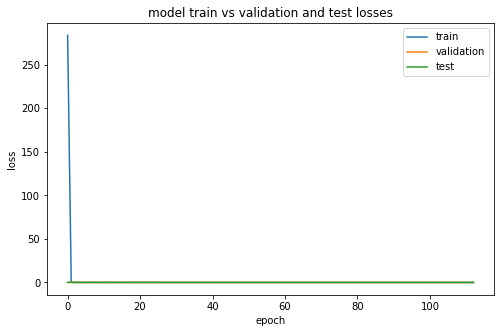

In [8]:
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(testResults)
plt.title('model train vs validation and test losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation', 'test'], loc='upper right')
plt.show()

64/64 [==============================] - 4s 64ms/step


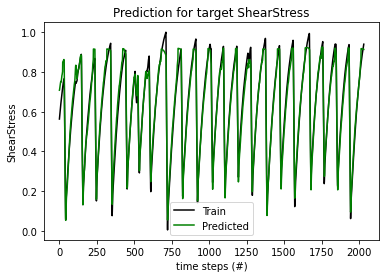

Train r2_score: 0.97711
Train RMSE: 0.03373


In [9]:
#Let's check the performance on train
trainPredict = model.predict(X_train)

for i in range(ntarget):
  plt.plot(y_train[:,i], color = 'black', label = 'Train')
  plt.plot(trainPredict[:,i], color = 'green', label = 'Predicted')
  plt.title('Prediction for target '+str(target[i]))
  plt.legend()
  plt.xlabel('time steps (#)')
  plt.ylabel(target[i])
  plt.show()
  rmse = sqrt(mean_squared_error(y_train[:,i], trainPredict[:,i]))
  r2=r2_score(y_train[:,i], trainPredict[:,i])
  print('Train r2_score: %.5f' % r2)
  print('Train RMSE: %.5f' % rmse)
  

29/29 [==============================] - 2s 64ms/step


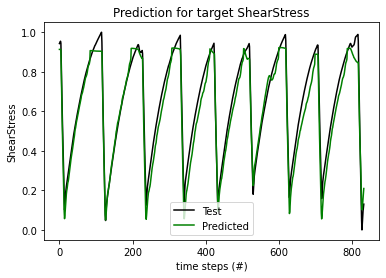

Test r2_score: 0.93997
Test RMSE: 0.06061


In [10]:
# Now let's check the performance on test
predicted = model.predict(X_test,verbose=1 )

for i in range(ntarget):
  plt.plot(y_test[:,i][:len(y_test[:,i])-steps], color = 'black', label = 'Test')
  plt.plot(predicted[:,i][:len(y_test[:,i])-steps], color = 'green', label = 'Predicted')
  plt.title('Prediction for target '+str(target[i]))
  plt.legend()
  plt.xlabel('time steps (#)')
  plt.ylabel(target[i])
  # plt_name='pt1_p'+ str(exp)+'_predicted_steps_'+ str(steps)+'_target_'+str(target[i])+'.pdf'
  # plt.savefig(plt_name)
  plt.show()
  rmse = sqrt(mean_squared_error(y_test[:,i][:len(y_test[:,i])-steps], predicted[:,i][:len(y_test[:,i])-steps]))
  r2=r2_score(y_test[:,i][:len(y_test[:,i])-steps], predicted[:,i][:len(y_test[:,i])-steps])
  print('Test r2_score: %.5f' % r2)
  print('Test RMSE: %.5f' % rmse)


In [11]:
results = model.evaluate(X_test, y_test, batch_size = 128)
print("test loss:", results)

8/8 [==============================] - 1s 125ms/step - loss: 0.0043
test loss: 0.004331200383603573
